In [1]:
import rmgpy
from rmgpy.molecule.resonance import *
from rmgpy.molecule.molecule import Molecule
from rmgpy.species import Species
from rmgpy.data.rmg import RMGDatabase
from lpsolve55 import lpsolve
import numpy as np

In [2]:
molecule = Molecule().fromSMILES('C1=CC=C2C(C=CC3C2=CC=C2C=CC=CC=32)=C1')

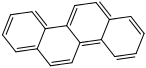

In [3]:
molecule

In [4]:
molecule.isAromatic()

False

In [5]:
SSSR = molecule.getAromaticSSSR()
SSSR

[[<Atom 'C'>, <Atom 'C'>, <Atom 'C'>, <Atom 'C'>, <Atom 'C'>, <Atom 'C'>],
 [<Atom 'C'>, <Atom 'C'>, <Atom 'C'>, <Atom 'C'>, <Atom 'C'>, <Atom 'C'>],
 [<Atom 'C'>, <Atom 'C'>, <Atom 'C'>, <Atom 'C'>, <Atom 'C'>, <Atom 'C'>],
 [<Atom 'C'>, <Atom 'C'>, <Atom 'C'>, <Atom 'C'>, <Atom 'C'>, <Atom 'C'>]]

In [12]:
atoms = set()
for ring in SSSR:
    atoms.update(ring)
atoms = list(atoms)

# Get list of bonds involving the ring atoms, ignoring bonds to hydrogen
bonds = set()
for atom in atoms:
    bonds.update([atom.bonds[key] for key in atom.bonds.keys() if key.isNonHydrogen()])
bonds = list(bonds)

# Connectivity matrix which indicates which rings and bonds each atom is in
# Part of equality constraint Ax=b
a = []
for atom in atoms:
    inRing = [1 if atom in ring else 0 for ring in SSSR]
    inBond = [1 if atom in [bond.atom1, bond.atom2] else 0 for bond in bonds]
    a.append(inRing + inBond)
z = [1] * len(SSSR) + [0] * len(bonds)

In [18]:
n = len(SSSR) + len(bonds)
lp = lpsolve('make_lp', len(atoms), n)
lpsolve('set_verbose', lp, 2)
lpsolve('set_obj_fn', lp, z)
lpsolve('set_maxim', lp)
lpsolve('set_mat', lp, a)
lpsolve('set_rh_vec', lp, [1] * len(atoms))
lpsolve('set_constr_type', lp, ['='] * len(atoms))
lpsolve('set_binary', lp, [True] * n)
lpsolve('solve', lp)
print lpsolve('get_solution', lp)
lpsolve('delete_lp', lp)

[2.0, [0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 1L]


In [9]:
a

[[1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
 [1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
 [0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,

In [11]:
len(a)

18

In [38]:
[c.value for c in lp.cols]

[1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0]

In [40]:
lp.kind

int